# Pipeline of the anomaly detection on the SKAB using Hotelling's $T^2$ statistic

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [ ]:
# libraries importing
import sys
import warnings

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("..")
from core.t2 import T2
from core.metrics import chp_score
from core.utils import load_skab

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

### Method initialization

In [ ]:
# classifier initializing
t2 = T2(scaling=True, using_pca=False)

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(["anomaly", "changepoint"], axis=1)

    # classifier fitting
    t2.fit(X_train)

    # results predicting
    t2.predict(
        df.drop(["anomaly", "changepoint"], axis=1),
        window_size=5,
        plot_fig=False,
    )
    prediction = pd.Series(
        (t2.t2["T2"].values > (2 * t2.t2_ucl)).astype(int), index=df.index
    ).fillna(0)
    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

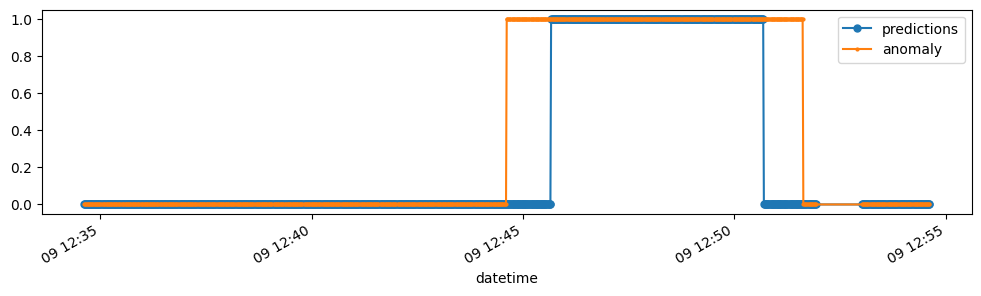

In [ ]:
# [donotremove]
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(
    figsize=(12, 3), label="predictions", marker="o", markersize=5
)
true_outlier[1].plot(marker="o", markersize=2)
plt.legend();

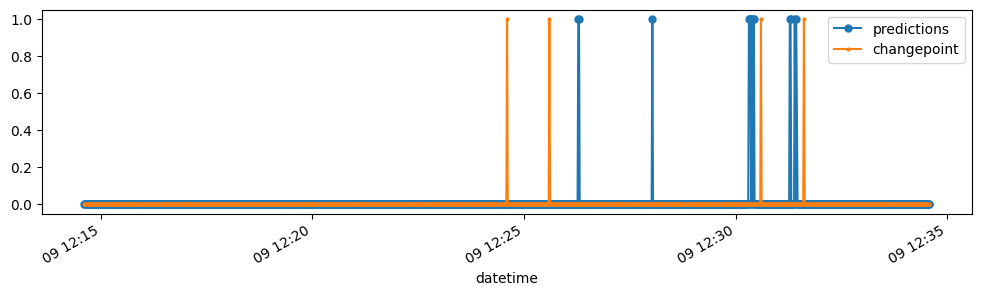

In [ ]:
# [donotremove]
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(
    figsize=(12, 3), label="predictions", marker="o", markersize=5
)
true_cp[0].plot(marker="o", markersize=2)
plt.legend();

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 8.71 %
Missing Alarm Rate 43.9 %
F1 metric 0.65


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 76
A number of FPs = 58
Average time 0 days 00:00:55.023584905


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  6.22
LowFP  -  -5.0
LowFN  -  12.41
